<a href="https://colab.research.google.com/github/ibrahimmansur4/HOID/blob/main/HOID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Object Interaction Detection Project

## Overview
This project focuses on the development of a robust Convolutional Neural Network (CNN) for the precise detection of human-object interactions in images. Leveraging computer vision and deep learning techniques, the model is trained on a curated dataset, extracted from videos capturing scenarios with and without interactions. The CNN's architecture, featuring convolutional, batch normalization, and dense layers, emphasizes both accuracy and interpretability. Extensive data augmentation ensures the model's generalization across diverse real-world scenarios.

## Table of Contents

- [Dataset](#dataset)
- [Data Preprocessing](#data-preprocessing)
  - [Label Conversion](#label-conversion)
  - [ImageDataGenerator Configuration](#imagedatagenerator-configuration)
  - [Image Data Generators](#image-data-generators)
  - [Class Distribution Counts](#class-distribution-counts)
- [Model Training](#model-training)
  - [Model Architecture](#model-architecture)
  - [Training Parameters](#training-parameters)
  - [Training Process](#training-process)
- [Performance Metrics](#performance-metrics)
  - [Evaluation on Test Set](#evaluation-on-test-set)
  - [Performance Metrics Calculation](#performance-metrics-calculation)
  - [Visual Representation](#visual-representation)
    - [Confusion Matrix Heatmap](#confusion-matrix-heatmap)
    - [ROC Curve](#roc-curve)
- [Live Webcam Interaction Detection](#live-webcam-interaction-detection)
- [Testing the Model with Images](#testing-the-model-with-images)
- [Conclusion](#conclusion)
- [Future Work](#future-work)






In [ ]:
# Import necessary libraries
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define paths to your videos
video_interaction_path = '/content/gdrive/MyDrive/Human Object Interaction/interaction_2.mp4'
video_non_interaction_path = '/content/gdrive/MyDrive/Human Object Interaction/non_interaction_2.mp4'

# Define paths to save extracted frames
interaction_frames_path = '/content/gdrive/MyDrive/Human Object Interaction/Our Dataset/interaction_frames/'
non_interaction_frames_path = '/content/gdrive/MyDrive/Human Object Interaction/Our Dataset/non_interaction_frames/'


# Dataset
- [Link to Dataset and trained model](https://drive.google.com/drive/folders/1kuJwON4OtbJQTkwTMKpSDAhD9BnbX7zq?usp=drive_link)

### Run this one time
- I have made the frames we just needs to access them now.
- Copy the code and run in a cell

```python
# Function to extract frames from video with skipping frames
def extract_frames(video_path, output_path, label, max_frames, skip_frames, start_frame_count=1):
    cap = cv2.VideoCapture(video_path)
    frame_count = start_frame_count

    while True:
        ret, frame = cap.read()
        if not ret or frame_count > start_frame_count + max_frames:
            break

        frame_count += 1

        # Skip frames to introduce variation
        for _ in range(skip_frames):
            ret, _ = cap.read()
            if not ret:
                break

        frame_filename = f"{output_path}{label}_{frame_count:04d}.jpg"
        cv2.imwrite(frame_filename, frame)

    cap.release()

# Create directories if they don't exist
os.makedirs(interaction_frames_path, exist_ok=True)
os.makedirs(non_interaction_frames_path, exist_ok=True)

# Find the starting frame count for each label
interaction_frame_count = len([f for f in os.listdir(interaction_frames_path) if f.endswith('.jpg') and f.startswith('1_')]) + 1
non_interaction_frame_count = len([f for f in os.listdir(non_interaction_frames_path) if f.endswith('.jpg') and f.startswith('0_')]) + 1

# Extract frames from new interaction video (starting from the last frame count)
extract_frames(video_interaction_path, interaction_frames_path, label=1, max_frames=2000, skip_frames=12, start_frame_count=interaction_frame_count)

# Extract frames from new non-interaction video (starting from the last frame count)
extract_frames(video_non_interaction_path, non_interaction_frames_path, label=0, max_frames=2000, skip_frames=12, start_frame_count=non_interaction_frame_count)

```

# Data Preprocessing

The dataset was organized into two categories: frames with human-object interaction (positive class) and frames without interaction (negative class). The following steps were taken to prepare the data for model training:

1. **Dataset Paths:**
   - Dataset root: `/content/gdrive/MyDrive/Human Object Interaction/Our Dataset`
   - Interaction frames directory: `interaction_frames`
   - Non-interaction frames directory: `non_interaction_frames`

2. **Image File Listing:**
   - Extracted all image files (with extensions .jpg or .png) from the interaction and non-interaction directories.

3. **DataFrame Creation:**
   - Created two DataFrames, `touch_df` and `not_touch_df`, containing file paths and labels (1 for interaction, 0 for non-interaction).
   - Combined the two DataFrames into `combined_df`.

4. **Train-Validation Split:**
   - Split the combined DataFrame into training (`train_df`) and validation (`val_df`) sets using a 80-20 split ratio.

5. **Data Augmentation:**
   - During model training, data augmentation was applied using the `ImageDataGenerator` from TensorFlow's Keras API.
   - Augmentation techniques included rotation, width shift, height shift, shear, zoom, and horizontal flip.

6. **Image Resizing and Normalization:**
   - Resized all images to a common size of (64, 64).
   - Normalized pixel values to the range [0, 1].

The preprocessed data was then used to train the interaction detection model.


In [ ]:
# Set the paths
dataset_root = '/content/gdrive/MyDrive/Human Object Interaction/Our Dataset'

touch_data_dir = f'{dataset_root}/interaction_frames'
not_touch_data_dir = f'{dataset_root}/non_interaction_frames'


# List all image files in the directories
touch_image_files = [os.path.join(touch_data_dir, file) for file in os.listdir(touch_data_dir) if file.endswith(('.jpg', '.png'))]
not_touch_image_files = [os.path.join(not_touch_data_dir, file) for file in os.listdir(not_touch_data_dir) if file.endswith(('.jpg', '.png'))]

# Create a DataFrame with file paths and labels
touch_df = pd.DataFrame({'filepath': touch_image_files, 'label': 1})
not_touch_df = pd.DataFrame({'filepath': not_touch_image_files, 'label': 0})

# Combine the dataframes
combined_df = pd.concat([touch_df, not_touch_df], ignore_index=True)

# Split the dataframe into train and validation sets
train_df, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)

# Data Augmentation and Image Data Generators

The following steps were taken to augment the training dataset and create image data generators:

1. **Label Conversion:**
   - Converted the 'label' column in the training and validation DataFrames to string format.

2. **ImageDataGenerator Configuration:**
   - Configured an `ImageDataGenerator` from TensorFlow's Keras API for data augmentation during model training.
   - Applied the following augmentation techniques:
     - Rescaling: Normalize pixel values to the range [0, 1].
     - Rotation: Randomly rotate images up to 40 degrees.
     - Width Shift: Randomly shift the width of images by up to 20%.
     - Height Shift: Randomly shift the height of images by up to 20%.
     - Shear: Randomly apply shearing transformations.
     - Zoom: Randomly zoom into images.
     - Horizontal Flip: Randomly flip images horizontally.
     - Fill Mode: Method to fill in newly created pixels.

3. **Image Data Generators:**
   - Created image data generators (`train_generator` and `val_generator`) using the `flow_from_dataframe` method.
   - Provided the DataFrames (`train_df` and `val_df`), image file paths, labels, target size, batch size, and class mode to the generators.

4. **Class Distribution Counts:**
   - Displayed the class distribution counts for both the training and validation sets.

These generators were utilized during model training to provide augmented batches of images.


In [ ]:
# Convert the 'label' column to string format
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Create ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

img_height, img_width = 64, 64
batch_size = 16

# Generate images with augmentation using flow_from_dataframe
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Count the occurrences of each class in the training set
train_class_counts = train_df['label'].value_counts()

# Count the occurrences of each class in the validation set
val_class_counts = val_df['label'].value_counts()

print("Training Class Counts:")
print(train_class_counts)

print("\nValidation Class Counts:")
print(val_class_counts)


Found 2900 validated image filenames belonging to 2 classes.
Found 726 validated image filenames belonging to 2 classes.
Training Class Counts:
1    1466
0    1434
Name: label, dtype: int64

Validation Class Counts:
1    387
0    339
Name: label, dtype: int64


# Model Training

## Model Architecture

The model architecture consists of the following layers:

1. Convolutional layer with 64 filters, kernel size (3, 3), and ReLU activation.
2. Batch Normalization layer.
3. MaxPooling layer with pool size (3, 3) and strides (2, 2).
4. Convolutional layer with 128 filters, kernel size (3, 3), and ReLU activation.
5. Batch Normalization layer.
6. MaxPooling layer with pool size (3, 3) and strides (2, 2).
7. Convolutional layer with 256 filters, kernel size (3, 3), and ReLU activation.
8. Batch Normalization layer.
9. MaxPooling layer with pool size (3, 3) and strides (2, 2).
10. Flatten layer.
11. Fully connected layer with 256 units and ReLU activation.
12. Fully connected layer with 128 units and ReLU activation.
13. Fully connected layer with 64 units and ReLU activation.
14. Output layer with 1 unit and sigmoid activation.

## Training Parameters

- Optimizer: Adam with a learning rate of 0.00001.
- Loss Function: Binary Crossentropy.
- Metrics: Accuracy.

## Training Process

The model was trained for 100 epochs using the following parameters:
- Batch Size: 16
- Image Size: (64, 64)
- Data Augmentation: Rotation, width shift, height shift, shear, zoom, horizontal flip.

Training involved the use of the training set and validation set, and the training progress was monitored through accuracy and loss metrics.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

num_epochs=100
# Define the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(


    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    verbose=1


)

Epoch 1/100
182/182 [==============================] - 294s 2s/step - loss: 0.6727 - accuracy: 0.6134 - val_loss: 0.7503 - val_accuracy: 0.5331
Epoch 2/100
182/182 [==============================] - 57s 310ms/step - loss: 0.5719 - accuracy: 0.6976 - val_loss: 0.6952 - val_accuracy: 0.5523
Epoch 3/100
182/182 [==============================] - 56s 305ms/step - loss: 0.5149 - accuracy: 0.7521 - val_loss: 0.5401 - val_accuracy: 0.7438
Epoch 4/100
182/182 [==============================] - 56s 306ms/step - loss: 0.4759 - accuracy: 0.7752 - val_loss: 0.4538 - val_accuracy: 0.8030
Epoch 5/100
182/182 [==============================] - 59s 322ms/step - loss: 0.4552 - accuracy: 0.7807 - val_loss: 0.4573 - val_accuracy: 0.7851
Epoch 6/100
182/182 [==============================] - 55s 300ms/step - loss: 0.4087 - accuracy: 0.8083 - val_loss: 0.3727 - val_accuracy: 0.8430
Epoch 7/100
182/182 [==============================] - 55s 304ms/step - loss: 0.3918 - accuracy: 0.8224 - val_loss: 0.3789 - v

# Training Visualization

The following plots showcase the training progress of the model over epochs. The first plot illustrates the training and validation accuracy, while the second plot displays the training and validation loss.


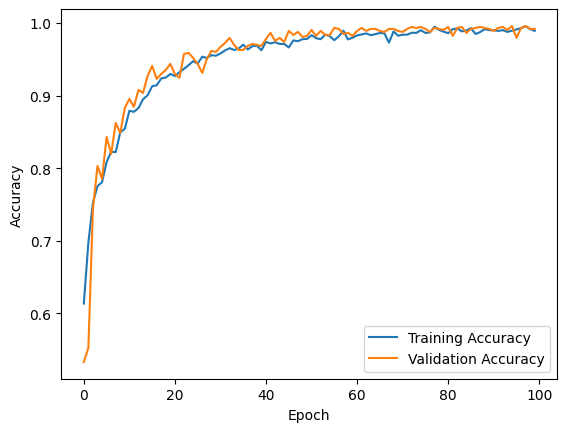

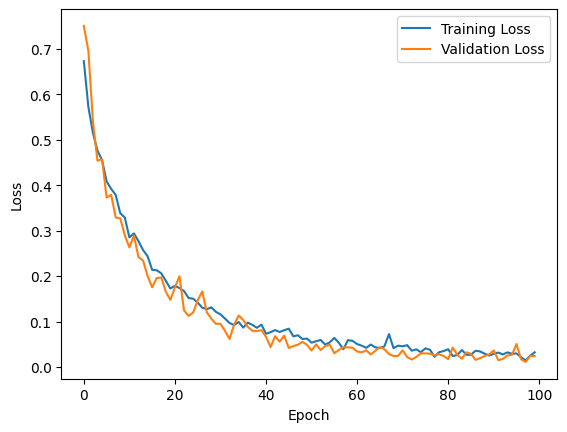

In [ ]:
import matplotlib.pyplot as plt

# Plot training/validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()
plt.show()

# Plot training/validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Testing with Single Image

To assess the model's performance on individual images, the following script loads a test image, preprocesses it, and makes predictions using the trained model.


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load a single test image
test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.12.31.jpeg'
# test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.13.05.jpeg'
# test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.13.06.jpeg'
# test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.13.04.jpeg'
img = load_img(test_image_path, target_size=(64, 64))  # Adjust target_size based on your model input size
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale to match the training data preprocessing

# Make predictions
predictions = model.predict(img_array)

# Post-process predictions (adjust this based on your output format)
predicted_class = 1 if predictions[0] > 0.5 else 0

# Display the test image
cv2_imshow(cv2.imread(test_image_path))
cv2.waitKey(0)
cv2.destroyAllWindows()

# Display predictions
print('Predicted Class:', predicted_class)


NameError: ignored

In [ ]:
# Save the model to Google Drive for future use
model.save('/content/gdrive/MyDrive/Human Object Interaction/Our Dataset/human_object_interaction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 408ms/step


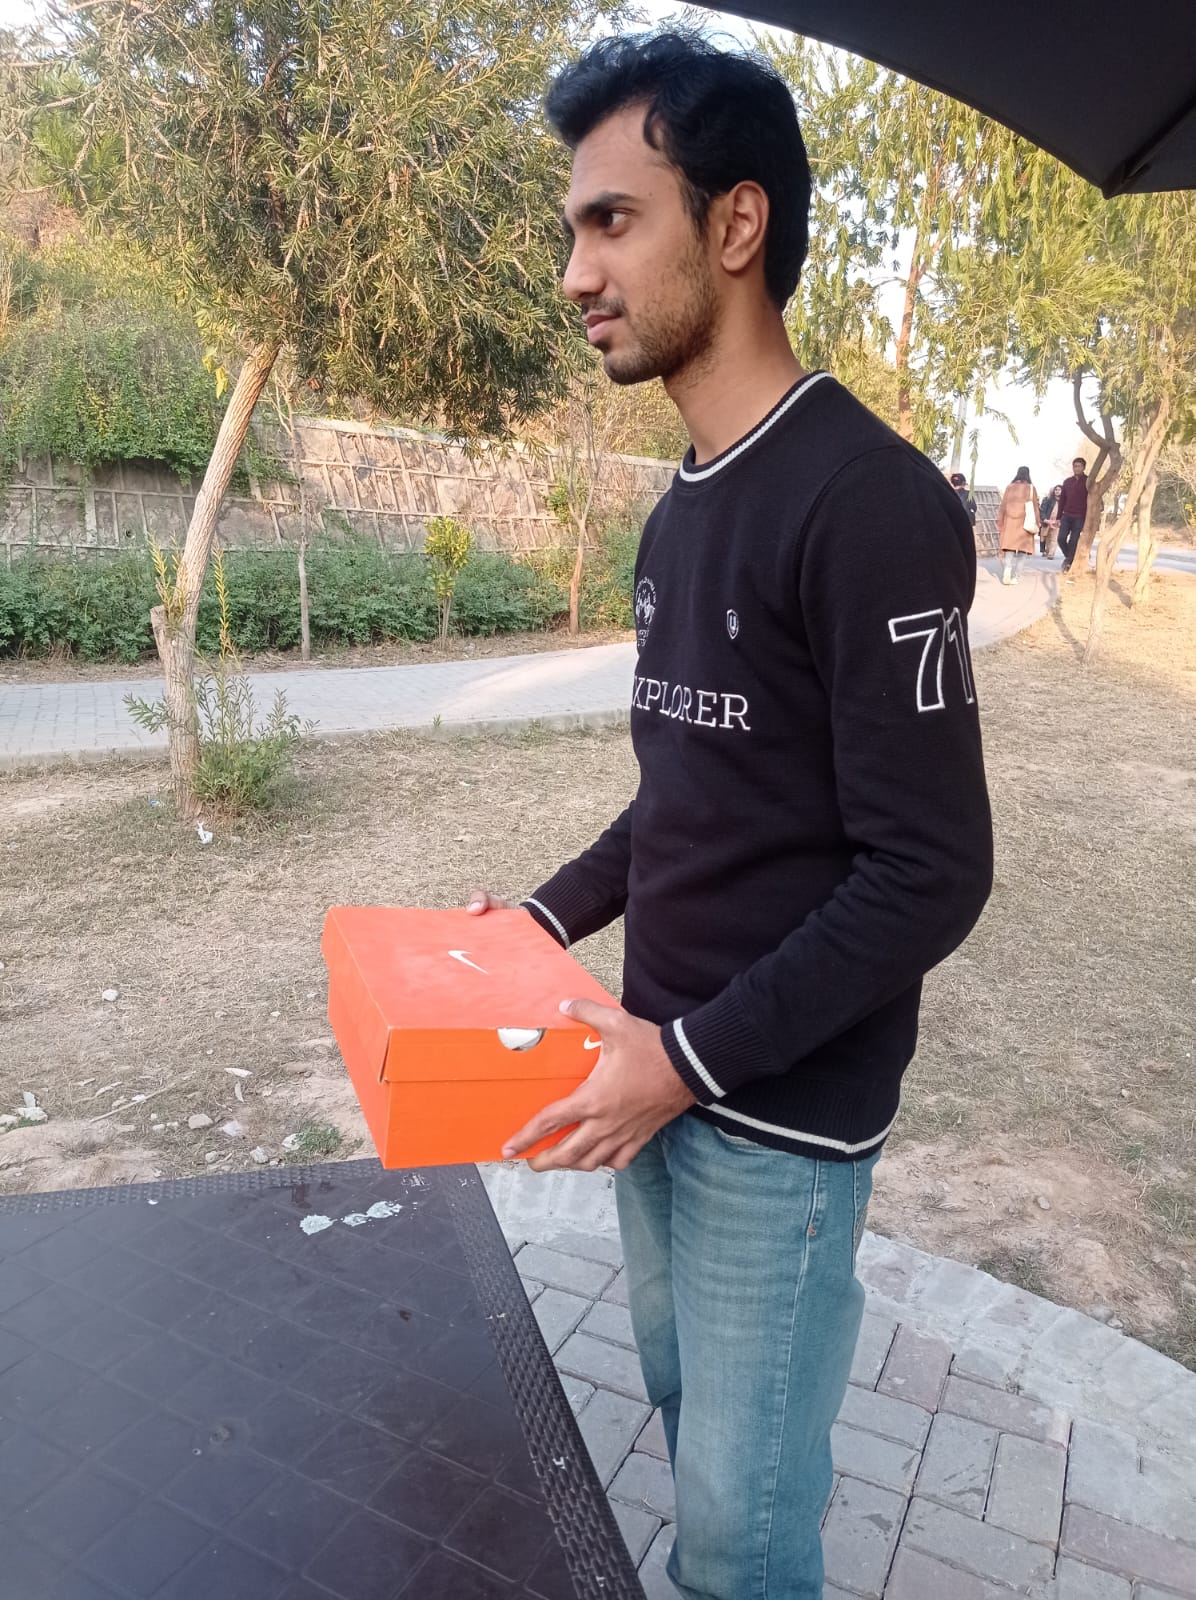

Predicted Class: 1


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab.patches import cv2_imshow

# Load the saved model
model_path = '/content/gdrive/MyDrive/Human Object Interaction/Our Dataset/human_object_interaction_model.h5'
loaded_model = load_model(model_path)

# Load a single test image
test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.12.31.jpeg'
# test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.13.05.jpeg'
# test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.13.06.jpeg'
# test_image_path = '/content/WhatsApp Image 2023-12-27 at 00.13.04.jpeg'
img = load_img(test_image_path, target_size=(64, 64))  # Adjust target_size based on your model input size
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale to match the training data preprocessing

# Make predictions
predictions = loaded_model.predict(img_array)

# Post-process predictions (adjust this based on your output format)
predicted_class = 1 if predictions[0] > 0.7 else 0

# Display the test image
cv2_imshow(cv2.imread(test_image_path))
cv2.waitKey(0)
cv2.destroyAllWindows()

# Display predictions
print('Predicted Class:', predicted_class)



# Performance Metrics
Evaluate the model's performance using various metrics:

- **Accuracy:** Measure of correct predictions.
- **Precision:** Proportion of true positive predictions.
- **Recall:** Proportion of actual positives correctly predicted.
- **F1 Score:** Harmonic mean of precision and recall.





Found 726 validated image filenames belonging to 2 classes.
46/46 [==============================] - 7s 152ms/step - loss: 0.0272 - accuracy: 0.9917
Test accuracy: 0.9917355179786682
46/46 [==============================] - 6s 127ms/step
Accuracy: 0.9944903581267218
Precision: 0.9922879177377892
Recall: 0.9974160206718347
F1 Score: 0.9948453608247424
Confusion Matrix:
[[336   3]
 [  1 386]]


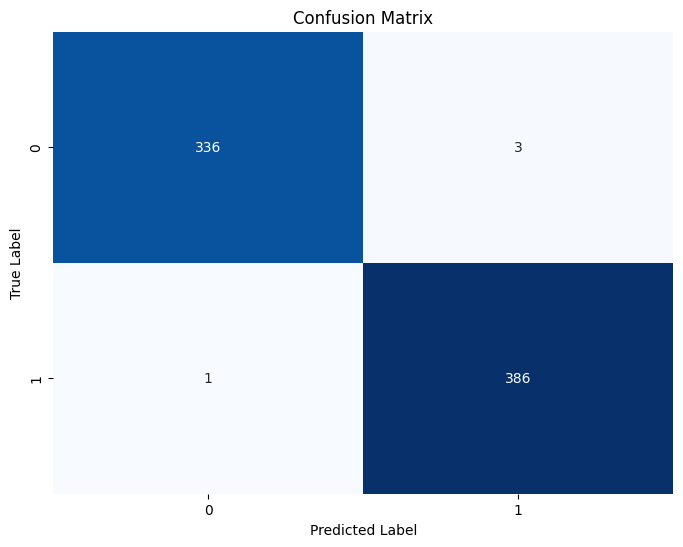

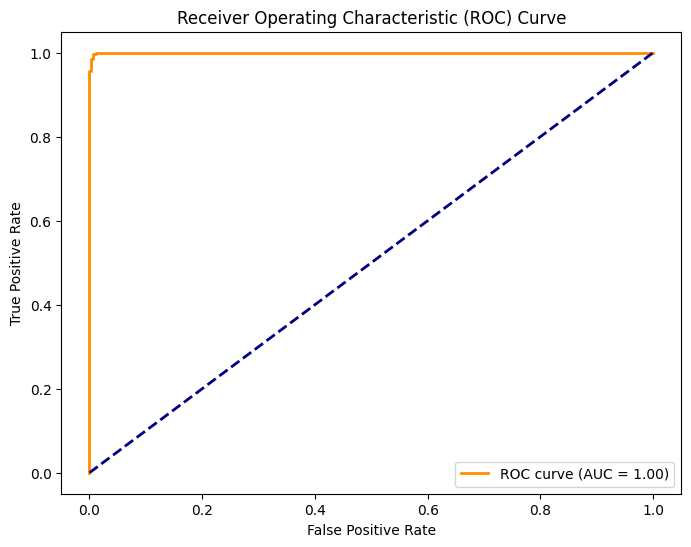

In [ ]:
# Evaluate the model on the test set
test_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure no shuffling for correct evaluation
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# Predictions on the test set
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.round(y_pred_probs)

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize performance metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Python script for running model on system(LINUX)
This section provides a Python script that allows you to run the trained model on a Linux system using your system's webcam.

### Instructions:

1. Ensure you have Python and OpenCV installed on your Linux system.
2. Replace `'/path/to/your/model/human_object_interaction_model.h5'` with the actual path to your trained model.
3. Copy and paste the provided script into a Python file (e.g., `run_model.py`).
4. Open a terminal and navigate to the directory containing the Python script.
5. Run the script using the command `python run_model.py`.
6. The script will open a window displaying the webcam feed with real-time interaction predictions.

### Script Explanation:

- The script loads the trained model using TensorFlow and OpenCV.
- It captures frames from the webcam, resizes them to the model input size, and normalizes pixel values.
- The model predicts whether object interaction is detected in real-time.
- The webcam feed and model predictions are displayed in a window.
- Press 'q' to exit the script

```python
import cv2
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model_path = '/path/to/your/model/human_object_interaction_model.h5'
model = keras.models.load_model(model_path)

# Open a connection to the webcam (assuming webcam index 0, adjust if needed)
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Resize the frame to match the input size of the model
    input_frame = cv2.resize(frame, (64, 64))

    # Preprocess the frame for model prediction
    input_frame = input_frame / 255.0  # Normalize pixel values
    input_frame = np.expand_dims(input_frame, axis=0)

    # Make predictions
    predictions = model.predict(input_frame)

    # Post-process predictions
    predicted_class = 1 if predictions[0] > 0.7 else 0

    # Display the frame
    cv2.imshow('Webcam', frame)

    # Display predictions
    print('Predicted Class:', predicted_class)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()
```

# Live Webcam Interaction Detection
This section demonstrates how to use the trained model for real-time interaction detection through a webcam. Follow the instructions below to interact with the model using your webcam.

### Instructions:

1. Run the provided code cell to activate the webcam and start live interaction detection.
2. A 'Capture' button will appear—click it to take a photo using your webcam.
3. The model will predict whether object interaction is detected or not based on the captured image.
4. Continue capturing images to see real-time predictions.
5. Press 'Ctrl+C' to stop the webcam and exit.

### Code Explanation:

The code utilizes JavaScript to create a 'Capture' button and access the webcam. It then captures frames, resizes them to match the model input size, and makes predictions for interaction detection.



In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Load the saved model
model_path = '/content/gdrive/MyDrive/Human Object Interaction/Our Dataset/human_object_interaction_model.h5'
loaded_model = load_model(model_path)

def take_photo(quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    return cv2.imdecode(np.frombuffer(binary, dtype=np.uint8), -1)

# Open the webcam and capture frames
while True:
    frame = take_photo()

    # Resize the frame to match the input size of the model
    input_frame = cv2.resize(frame, (64, 64))

    # Preprocess the frame for model prediction
    input_frame = img_to_array(input_frame)
    input_frame = np.expand_dims(input_frame, axis=0)
    input_frame = preprocess_input(input_frame)

    # Make predictions
    predictions = loaded_model.predict(input_frame)
    predicted_class = 1 if predictions[0] > 0.5 else 0

    # Display predictions
    if predicted_class == 1:
        print('Object Interaction Detected')
    else:
        print('No Object Interaction Detected')



# Conclusion
The project not only achieves exceptional accuracy but also provides insights into the interpretability and practical applicability of the developed model. The ongoing exploration of new techniques and datasets positions this project at the forefront of advancements in human-object interaction detection.

# Future Work
### Diverse Dataset Expansion:

- The project's performance could be further enhanced by expanding the dataset to encompass a more diverse range of human-object interaction scenarios and environmental conditions. This would contribute to improved model adaptability and generalization in real-world settings.

### Architectural Exploration:

- Exploring alternative CNN architectures or incorporating attention mechanisms could optimize the model's ability to capture intricate interaction patterns. Experimenting with architectures tailored for specific interaction scenarios may contribute to enhanced accuracy and efficiency.

### Computational Efficiency:

- While the current model demonstrates high accuracy, future enhancements could focus on improving computational efficiency. Investigating techniques for model compression or exploring lightweight architectures would facilitate deployment in resource-constrained environments without compromising accuracy.